In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import json


from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from scipy.stats import gaussian_kde, pearsonr, spearmanr 

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as patches



In [17]:
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_colwidth', 20)
pd.set_option('display.max_rows', None) 

In [2]:
gene = "PTPN11"

In [3]:
# Read the df
df_stat = pd.read_csv(r"\\rdp.arc.ucl.ac.uk\ritd-ag-project-rd025c-bhall50\ModellingRASopathies RDSS\PTPN11_ClinVar_REVEL_BayesDel.csv")


In [116]:
df_stat

,GRCh38Location,GRCh37Location,Protein change,Germline classification,REVEL,BayesDel_noAF,BayesDel_addAF,AAfrom,AAto,AApos_ClinVar
0,112419113,112856917,M1R,Likely pathogenic,0.202,0.660000,0.660000,M,R,1
1,112419116,112856920,T2I,Pathogenic/Likely pathogenic,0.213,0.010807,0.010807,T,I,2
2,112419121,112856925,R4G,Conflicting classifications of pathogenicity,0.518,0.044882,0.044882,R,G,4
3,112419122,112856926,R4Q,Likely pathogenic,0.393,-0.022043,-0.022043,R,Q,4
4,112446279,112884083,W6C,Uncertain significance,0.920,0.512606,0.512606,W,C,6
...,...,...,...,...,...,...,...,...,...,...
583,112504745,112942549,Q587R,Uncertain significance,0.182,-0.213665,-0.213665,Q,R,587
584,112504745,112942549,Q588R,Uncertain significance,0.182,-0.213665,-0.213665,Q,R,588
585,112504748,112942552,Q588P,Uncertain significance,0.248,-0.135998,-0.135998,Q,P,588
586,112504748,112942552,Q589P,Uncertain significance,0.248,-0.135998,-0.135998,Q,P,589


In [42]:
def plot_score_density(df, score, gene=None, bw_adjust=0.5):
    plt.figure(figsize=(4, 3))
    sns.kdeplot(df[score].dropna(), fill=True, bw_adjust=bw_adjust)
    title = f"Density Plot of {score} Scores"
    title += f" for {gene} Variants"
    plt.title(title)
    plt.xlabel(f"{score} Score")
    plt.ylabel("Density")
    if score == 'REVEL':
        plt.xlim(0,1)
    plt.show()


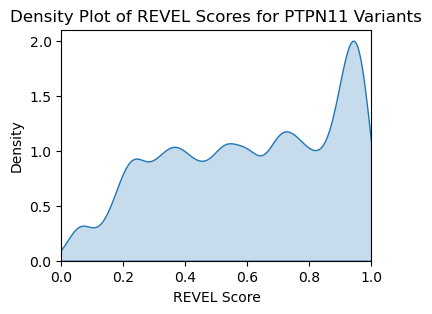

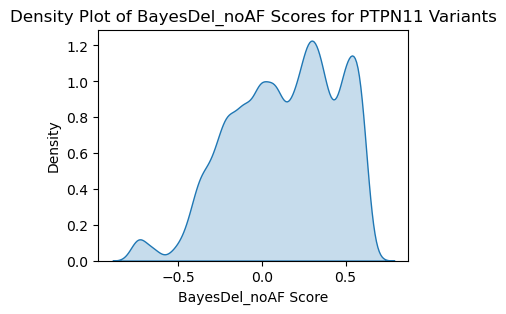

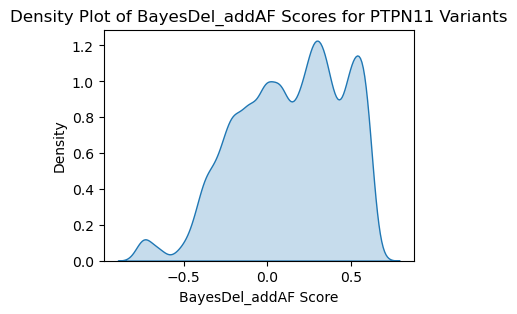

In [43]:
plot_score_density(df_stat, 'REVEL', gene='PTPN11')
plot_score_density(df_stat, 'BayesDel_noAF', gene='PTPN11')
plot_score_density(df_stat, 'BayesDel_addAF', gene='PTPN11')


In [34]:
# Mapping Germline classification to groups
class_map = {**dict.fromkeys(['Pathogenic', 'Likely pathogenic', 'Pathogenic/Likely pathogenic'], 'Pathogenic'),
             **dict.fromkeys(['Benign', 'Likely benign', 'Benign/Likely benign'], 'Benign'),
             **dict.fromkeys(['Uncertain significance','Uncertain significance; risk factor','Conflicting classifications of pathogenicity','other'], 'Uncertain')}

In [57]:
def plot_score_density_group(df, score, class_map, gene=None,  classification_col="Germline classification", bw_adjust=0.5):

    # Filter by gene
    if gene and "Gene" in df.columns:
        df = df[df["Gene"] == gene]

    df = df.copy()
    df["Germline_Group"] = df[classification_col].map(class_map).fillna("Other")

    # Drop rows with missing score or group
    data = df[[score, "Germline_Group"]].dropna()

    # Define consistent palette and order
    full_order = ['Pathogenic', 'Benign', 'Uncertain', 'Other']
    present_order = [g for g in full_order if g in data["Germline_Group"].unique()]
    palette = {
        'Pathogenic': '#d73027',
        'Benign': '#1a9850',
        'Uncertain': '#fee08b',
        'Other': '#aaaaaa'
    }

    plt.figure(figsize=(4, 3))
    ax = sns.kdeplot(
        data=data,
        x=score,
        hue="Germline_Group",
        hue_order=present_order,
        fill=True,
        common_norm=False,
        bw_adjust=bw_adjust,
        alpha=0.4,
        linewidth=1.2,
        palette=palette
    )

    # Formatting
    plt.title(f"Density of {score} Scores{' for ' + gene if gene else ''}", fontsize=10)
    plt.xlabel(f"{score} Score")
    plt.ylabel("Density")
    if score.upper() == "REVEL":
        plt.xlim(0, 1)

    plt.tight_layout()
    plt.show()


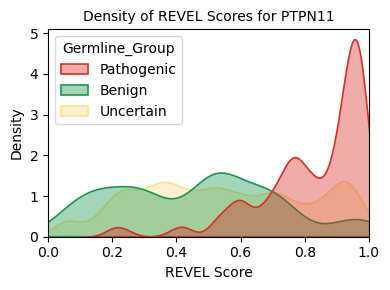

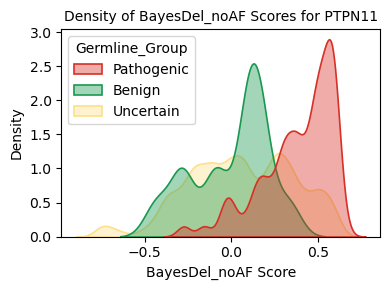

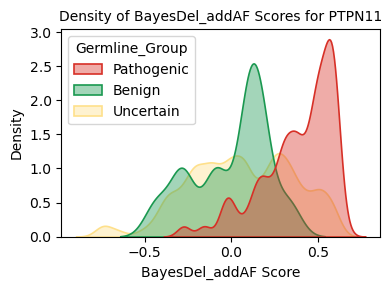

In [58]:
plot_score_density_group(df_stat, 'REVEL', class_map, gene='PTPN11')
plot_score_density_group(df_stat, 'BayesDel_noAF', class_map, gene='PTPN11')
plot_score_density_group(df_stat, 'BayesDel_addAF', class_map, gene='PTPN11')


In [8]:
def compute_roc_and_label(df_stat, score, label='Germline classification', gene=None):

    # Map classifications to binary labels
    pathogenic_classes = ['Pathogenic', 'Likely pathogenic', 'Pathogenic/Likely pathogenic']
    benign_classes = ['Benign', 'Likely benign', 'Benign/Likely benign']
    
    prob_map = {cls: 1 for cls in pathogenic_classes}
    prob_map.update({cls: 0 for cls in benign_classes})
    
    # Filter to only rows with defined ClinVar labels
    df_stat_ROC = df_stat[df_stat[label].isin(prob_map.keys())].copy()
    df_stat_ROC['label'] = df_stat_ROC[label].map(prob_map)
    
    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(df_stat_ROC['label'], df_stat_ROC[score])
    roc_auc = roc_auc_score(df_stat_ROC['label'], df_stat_ROC[score])
    
    # Optimal cutoff using Youden's J statistic
    youden_j = tpr - fpr
    optimal_idx = np.argmax(youden_j)
    optimal_threshold = thresholds[optimal_idx]
    optimal_thresholds_dict = {score: optimal_threshold}
    
    # Plot ROC curve
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0,1], [0,1], linestyle='--', color='gray')
    plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label=f'Optimal cutoff = {optimal_threshold:.3f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    title = f"{gene + ' ' if gene else ''}{score} ROC Curve"
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Classify variants using optimal cutoff
    pred_col = f"Predicted_{score}"
    
    df_stat_ROC[f"Predicted_{score}"] = np.where(df_stat_ROC[score] >= optimal_threshold, 'Pathogenic', 'Benign')
    df_stat_ROC[f'Predicted_{score}_numeric'] = df_stat_ROC[f"Predicted_{score}"].map({'Benign': 0, 'Pathogenic': 1})
    
    # Compute confusion matrix
    tn, fp, fn, tp = confusion_matrix(df_stat_ROC['label'], df_stat_ROC[f'Predicted_{score}_numeric']).ravel()

    # Compute metrics
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tp / (tp + fn)  # True Positive Rate
    specificity = tn / (tn + fp)  # True Negative Rate

    # Classify variants using optimal cutoff
    df_out = df_stat.copy()
    df_out[pred_col] = np.where(df_out[score] >= optimal_threshold, 'Pathogenic',
                                np.where(df_out[score].notna(), 'Benign', None)).astype(object)

    
    print(f"Optimal {score} cutoff for {gene if gene else 'gene'}: {optimal_threshold:.3f}")
    print(f"ROC AUC: {roc_auc:.3f}")
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Sensitivity (TPR): {sensitivity:.3f}")
    print(f"Specificity (TNR): {specificity:.3f}")
    
    return df_out, roc_auc, optimal_threshold, accuracy, sensitivity, specificity


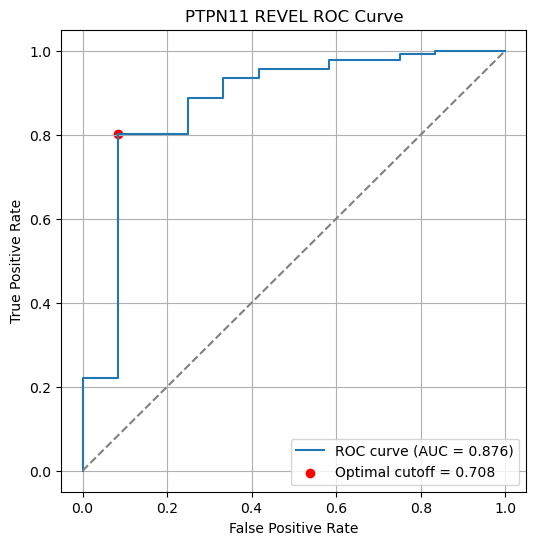

Optimal REVEL cutoff for PTPN11: 0.708
ROC AUC: 0.876
Accuracy: 0.810
Sensitivity (TPR): 0.801
Specificity (TNR): 0.917


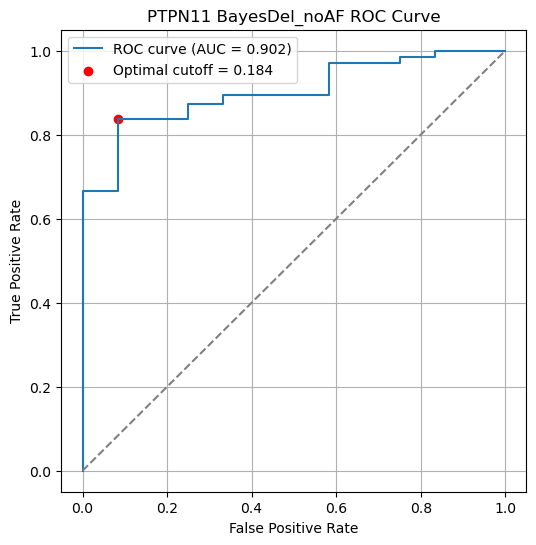

Optimal BayesDel_noAF cutoff for PTPN11: 0.184
ROC AUC: 0.902
Accuracy: 0.843
Sensitivity (TPR): 0.837
Specificity (TNR): 0.917


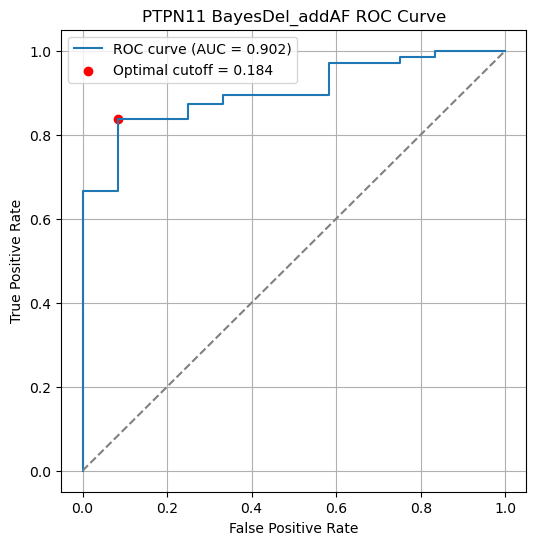

Optimal BayesDel_addAF cutoff for PTPN11: 0.184
ROC AUC: 0.902
Accuracy: 0.843
Sensitivity (TPR): 0.837
Specificity (TNR): 0.917


In [9]:
# REVEL
revel_labeled, revel_auc, revel_cutoff, revel_accuracy, revel_sensitivity, revel_specificity = compute_roc_and_label(
    df_stat, 
    score='REVEL', 
    gene='PTPN11')

# BayesDel_noAF
noaf_labeled, noaf_auc, noaf_cutoff, noaf_accuracy, noaf_sensitivity, noaf_specificity = compute_roc_and_label(
    df_stat, 
    score='BayesDel_noAF', 
    gene='PTPN11')

# BayesDel_addAF
addaf_labeled, addaf_auc, addaf_cutoff, addaf_accuracy, addaf_sensitivity, addaf_specificity = compute_roc_and_label(
    df_stat, 
    score='BayesDel_addAF', 
    gene='PTPN11')

In [10]:
thresholds = {
    'REVEL': revel_cutoff,
    'BayesDel_noAF': noaf_cutoff,
    'BayesDel_addAF': addaf_cutoff
}

print(thresholds)

{'REVEL': np.float64(0.708), 'BayesDel_noAF': np.float64(0.183634), 'BayesDel_addAF': np.float64(0.183634)}


In [10]:
# Combine predicted labels

df_combined = revel_labeled.copy()
df_combined['Predicted_BayesDel_noAF'] = noaf_labeled['Predicted_BayesDel_noAF']
df_combined['Predicted_BayesDel_addAF'] = addaf_labeled['Predicted_BayesDel_addAF']

# Save
output_path = r"\\rdp.arc.ucl.ac.uk\ritd-ag-project-rd025c-bhall50\ModellingRASopathies RDSS\PTPN11_REVEL_BayesDel_labeled.csv"
df_combined.to_csv(output_path, index=False)


In [4]:
PTPN11_REVEL_BayesDel_labeled_df = pd.read_csv(r"\\rdp.arc.ucl.ac.uk\ritd-ag-project-rd025c-bhall50\ModellingRASopathies RDSS\PTPN11_REVEL_BayesDel_labeled.csv")


In [15]:
def plot_density_by_predicted_class(df, score, gene=None, cutoff=None, alpha=0.4, figsize=(8,6)):
    pred_col = f'Predicted_{score}'
    
    # Compute medians
    medians = df.groupby(pred_col)[score].median()
    
    # Plot density
    plt.figure(figsize=figsize)
    sns.kdeplot(data=df, x=score, hue=pred_col, fill=True, common_norm=False, alpha=alpha)
    
    # Add median lines
    for label, median_val in medians.items():
        plt.axvline(median_val, linestyle='--', label=f'{label} median = {median_val:.3f}')
    
    # Add cutoff line
    if cutoff is not None:
        plt.axvline(cutoff, color='black', linestyle='-', linewidth=2, label=f'Cutoff = {cutoff:.3f}')
    
    plt.xlabel(f'{score} Score')
    plt.ylabel('Density')
    plt.title(f"{gene + ' ' if gene else ''}{score} Scores by Predicted Class")
    plt.legend()
    plt.grid(True)
    plt.show()


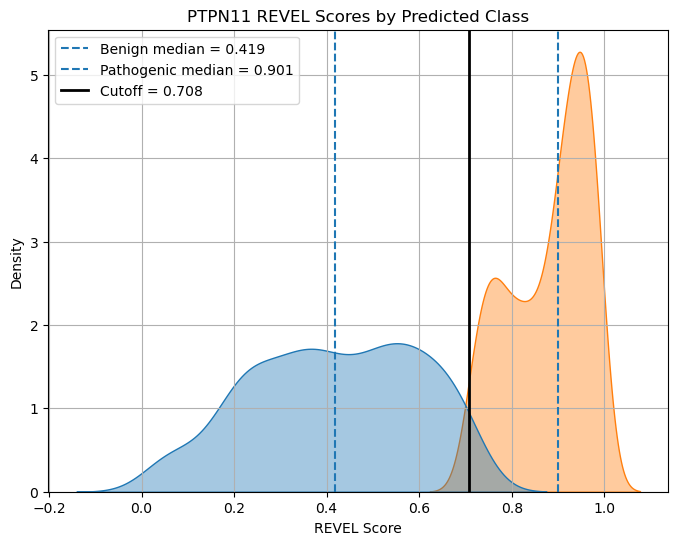

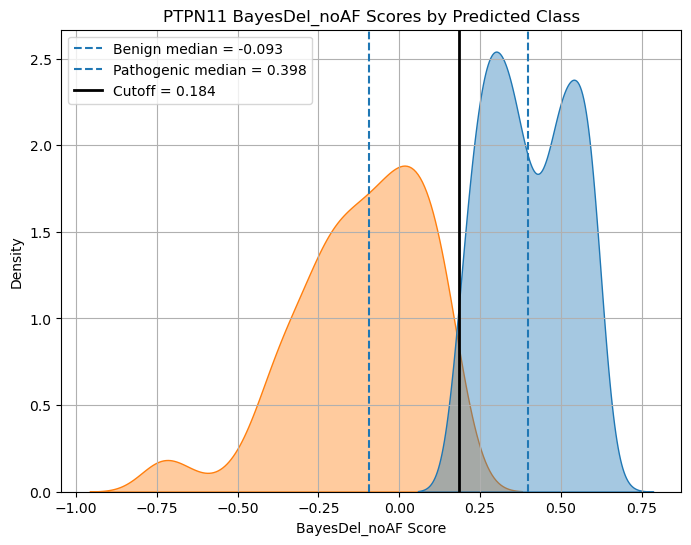

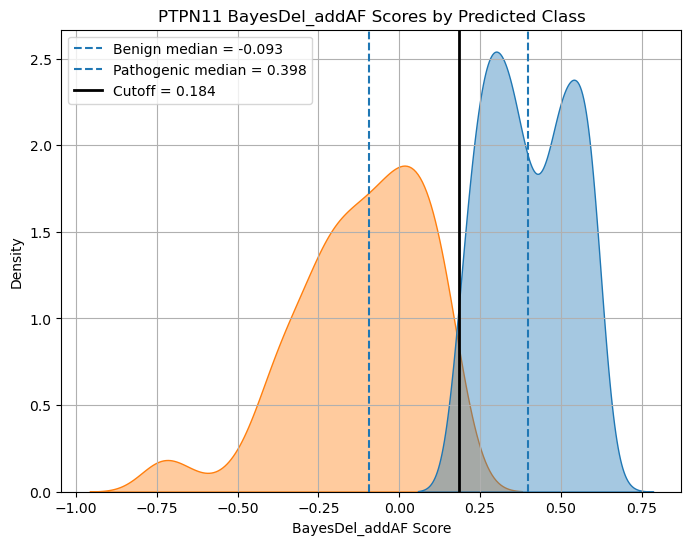

In [16]:

plot_density_by_predicted_class(PTPN11_REVEL_BayesDel_labeled_df, score='REVEL', gene='PTPN11', cutoff=revel_cutoff)
plot_density_by_predicted_class(PTPN11_REVEL_BayesDel_labeled_df, 'BayesDel_noAF', gene='PTPN11', cutoff=noaf_cutoff)
plot_density_by_predicted_class(PTPN11_REVEL_BayesDel_labeled_df, 'BayesDel_addAF', gene='PTPN11', cutoff=addaf_cutoff)



In [12]:
def plot_density_combined_class(df, score, gene=None, cutoff=None, bw_adjust=0.5):
    pred_col = f"Predicted_{score}"
    df_plot = df[[score, pred_col]].dropna()

    # Split data
    pathogenic = df_plot[df_plot[pred_col] == 'Pathogenic'][score]
    benign = df_plot[df_plot[pred_col] == 'Benign'][score]

    # KDEs
    x = np.linspace(df_plot[score].min(), df_plot[score].max(), 200)
    kde_combined = gaussian_kde(pathogenic, bw_method=bw_adjust)(x) + gaussian_kde(benign, bw_method=bw_adjust)(x)

    # Plot
    plt.figure()
    plt.plot(x, kde_combined, color='black', linewidth=2)

    # Cutoff
    if cutoff is not None:
        plt.axvline(cutoff, color='blue', linestyle='-', linewidth=2, label=f'Cutoff = {cutoff:.3f}')

    plt.xlabel(f"{score} Score")
    plt.ylabel("Density")
    plt.title(f"{gene if gene else ''} {score} Combined Predicted Density")
    plt.legend()
    plt.grid(True)
    plt.show()


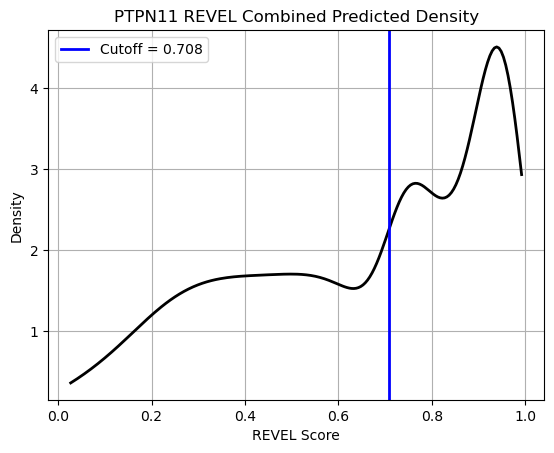

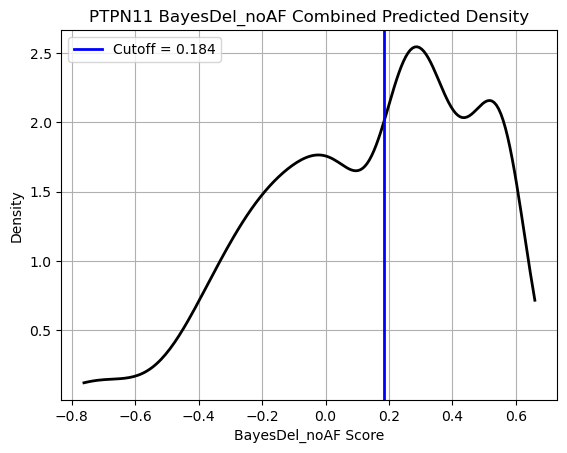

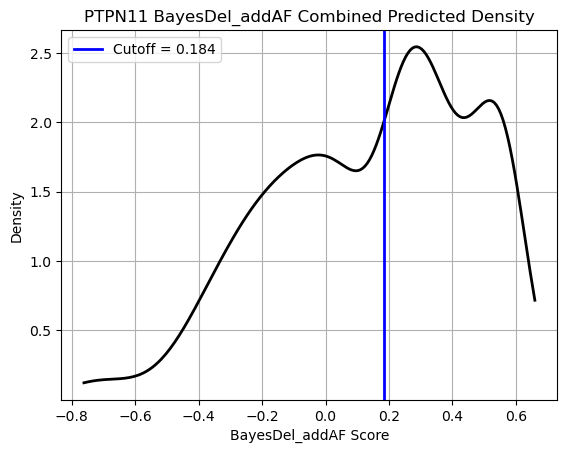

In [13]:
plot_density_combined_class(PTPN11_REVEL_BayesDel_labeled_df, score='REVEL', gene='PTPN11', cutoff=revel_cutoff)
plot_density_combined_class(PTPN11_REVEL_BayesDel_labeled_df, 'BayesDel_noAF', gene='PTPN11', cutoff=noaf_cutoff)
plot_density_combined_class(PTPN11_REVEL_BayesDel_labeled_df, 'BayesDel_addAF', gene='PTPN11', cutoff=addaf_cutoff)


In [11]:
# Load the saved UniProt features
with open(f"{gene}_features.json", "r") as f:
    all_features = json.load(f)

domains = all_features["domains"]
sites = all_features["sites"]

In [17]:
# Filter misclassified
mismatches = PTPN11_REVEL_BayesDel_labeled_df[
    (
        PTPN11_REVEL_BayesDel_labeled_df['Germline classification'].isin(pathogenic_classes) &
        ~(
            (PTPN11_REVEL_BayesDel_labeled_df['Predicted_REVEL'] == 'Pathogenic') &
            (PTPN11_REVEL_BayesDel_labeled_df['Predicted_BayesDel_noAF'] == 'Pathogenic') &
            (PTPN11_REVEL_BayesDel_labeled_df['Predicted_BayesDel_addAF'] == 'Pathogenic')
        )
    ) |
    (
        PTPN11_REVEL_BayesDel_labeled_df['Germline classification'].isin(benign_classes) &
        ~(
            (PTPN11_REVEL_BayesDel_labeled_df['Predicted_REVEL'] == 'Benign') &
            (PTPN11_REVEL_BayesDel_labeled_df['Predicted_BayesDel_noAF'] == 'Benign') &
            (PTPN11_REVEL_BayesDel_labeled_df['Predicted_BayesDel_addAF'] == 'Benign')
        )
    )
]

print(f"Number of mismatched rows: {len(mismatches)}")
mismatches

Number of mismatched rows: 40


,GRCh38Location,GRCh37Location,Protein change,Germline classification,REVEL,BayesDel_noAF,BayesDel_addAF,AAfrom,AAto,AApos_ClinVar,Predicted_REVEL,Predicted_BayesDel_noAF,Predicted_BayesDel_addAF
0,112419113,112856917,M1R,Likely pathogenic,0.202,0.660000,0.660000,M,R,1,Benign,Pathogenic,Pathogenic
1,112419116,112856920,T2I,Pathogenic/Likely pathogenic,0.213,0.010807,0.010807,T,I,2,Benign,Benign,Benign
3,112419122,112856926,R4Q,Likely pathogenic,0.393,-0.022043,-0.022043,R,Q,4,Benign,Benign,Benign
27,112446385,112884189,T42S,Likely pathogenic,0.612,-0.040817,-0.040817,T,S,42,Benign,Benign,Benign
28,112446385,112884189,T42A,Pathogenic,0.794,0.144697,0.144697,T,A,42,Pathogenic,Benign,Benign
37,112450346,112888150,I56V,Pathogenic,0.772,0.160158,0.160158,I,V,56,Pathogenic,Benign,Benign
41,112450352,112888156,N58D,Pathogenic,0.757,-0.052343,-0.052343,N,D,58,Pathogenic,Benign,Benign
42,112450352,112888156,N58H,Pathogenic,0.760,-0.024088,-0.024088,N,H,58,Pathogenic,Benign,Benign
44,112450354,112888158,N58K,Pathogenic/Likely pathogenic,0.589,-0.156259,-0.156259,N,K,58,Benign,Benign,Benign
45,112450354,112888158,N58K,Pathogenic,0.589,-0.156259,-0.156259,N,K,58,Benign,Benign,Benign


In [20]:
def plot_score_by_position(
    df,
    score='REVEL',
    cutoff=None,
    position_col='AApos_ClinVar',
    label_col='Germline classification',
    pred_col = None,
    pathogenic_classes=None,
    benign_classes=None,
    uncertain_classes=None,
    domains=None,
    sites=None,
    title=None
):
    # Build palette
    pathogenic_classes = ['Pathogenic', 'Likely pathogenic', 'Pathogenic/Likely pathogenic']
    benign_classes = ['Benign', 'Likely benign', 'Benign/Likely benign']
    palette = {}
    palette.update({cls: 'red' for cls in pathogenic_classes})
    palette.update({cls: 'green' for cls in benign_classes})
    for label in df[label_col].unique():
        if label not in palette:
            palette[label] = 'lightgrey'

    # Scatter plot
    plt.figure(figsize=(12,6))
    sns.scatterplot(
        data=df,
        x=position_col,
        y=score,
        hue=label_col,
        palette=palette,
        alpha=0.7
    )
    
    # Highlight misclassified amino acid positions
    if pred_col:
        # Group by position and count mispredictions
        df_mis_patho = df[df[label_col].isin(pathogenic_classes) & (df[pred_col] == 'Benign')]
        df_mis_benign = df[df[label_col].isin(benign_classes) & (df[pred_col] == 'Pathogenic')]

        for pos, count in df_mis_patho[position_col].value_counts().items():
            plt.axvspan(pos-0.5, pos+0.5, color='red', alpha=min(0.1 + 0.05*count, 0.5))
        for pos, count in df_mis_benign[position_col].value_counts().items():
            plt.axvspan(pos-0.5, pos+0.5, color='green', alpha=min(0.1 + 0.05*count, 0.5))


    # Add cutoff line
    if cutoff is not None:
        plt.axhline(y=cutoff, color='black', linestyle='--', linewidth=1.5)
        plt.text(df[position_col].min(), cutoff + 0.02,
                 f'Cut-off = {cutoff}', color='black', fontsize=10, fontweight='bold')

    plt.xlabel('Amino Acid Position')
    plt.ylabel(f'{score} Score')
    plt.title(title or f'{score} Scores Colored by ClinVar Classification')
    plt.grid(True)

    # Add domains
    if domains:
        ymin, ymax = plt.ylim()
        domain_height = 0.05 * (ymax - ymin)
        for domain in domains:
            name, start, end, colour = domain
            plt.gca().add_patch(
                patches.Rectangle(
                    (start, ymin),
                    end-start+1,
                    domain_height,
                    facecolor=colour,
                    alpha=0.3,
                    edgecolor='black'
                )
            )
            plt.text((start+end)/2, ymin + domain_height/2, name,
                     ha='center', va='center', fontsize=8)

    # Add sites
    if sites:
        ymin, ymax = plt.ylim()
        domain_height = 0.05 * (ymax - ymin) if domains else 0
        for site in sites:
            name, start, end, colour = site
            y_offset = 0.05 if colour == "#e78ac3" else 0.02
            y_base = ymin + domain_height + y_offset*(ymax - ymin)

            for pos in range(start, end + 1):
                plt.scatter(pos, y_base, marker='*', s=100, c=[colour], edgecolor='black', zorder=10)
            midpoint = (start + end) / 2
            plt.text(midpoint, y_base + 0.02*(ymax - ymin), name,
                     ha='center', va='bottom', fontsize=7, rotation=90)

    # Custom legend
    custom_legend = [
        Line2D([0], [0], marker='o', c='w', label='Pathogenics', markerfacecolor='red', markersize=8),
        Line2D([0], [0], marker='o', c='w', label='Benigns', markerfacecolor='green', markersize=8),
        Line2D([0], [0], marker='o', c='w', label='Uncertain/Other', markerfacecolor='lightgrey', markersize=8)
    ]
    plt.legend(handles=custom_legend, title='Classifications:')

    plt.show()


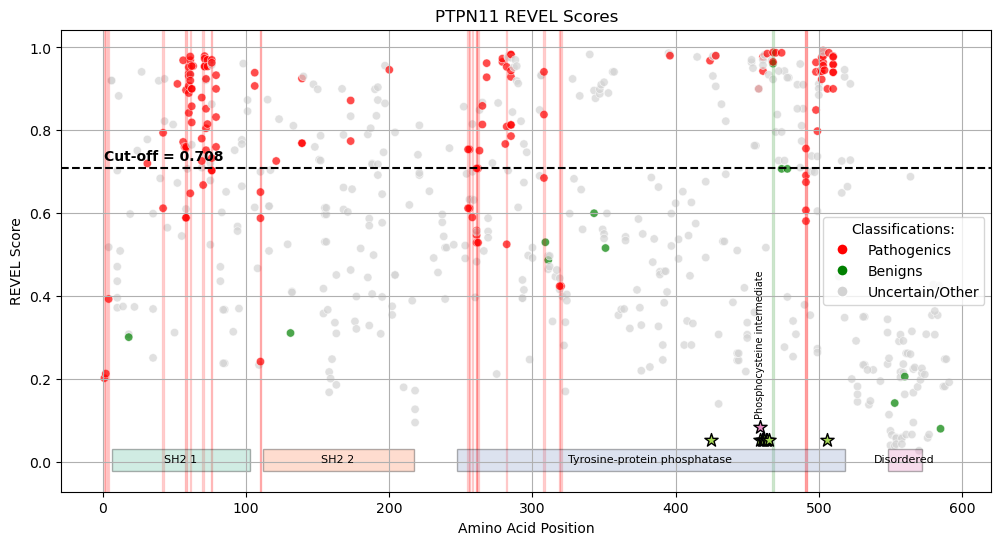

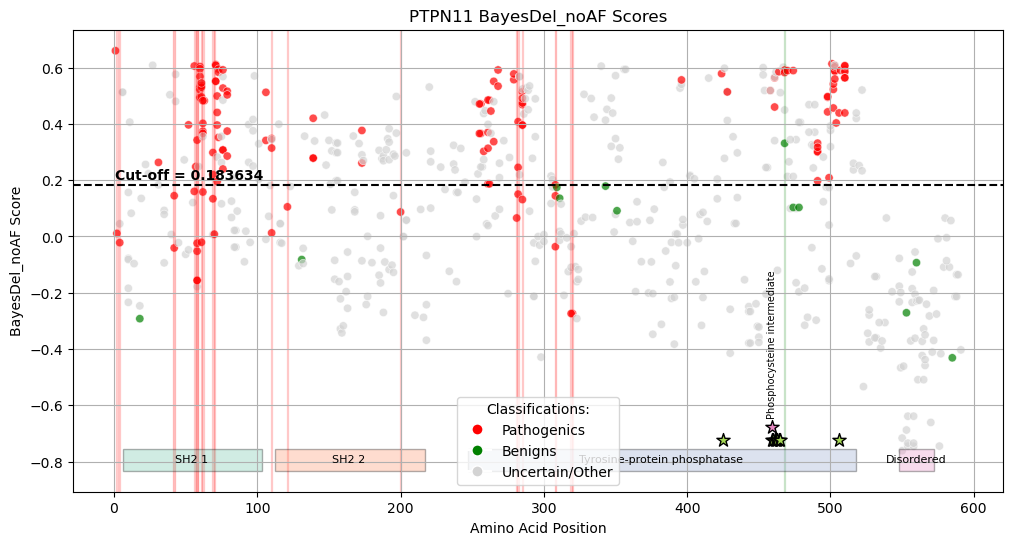

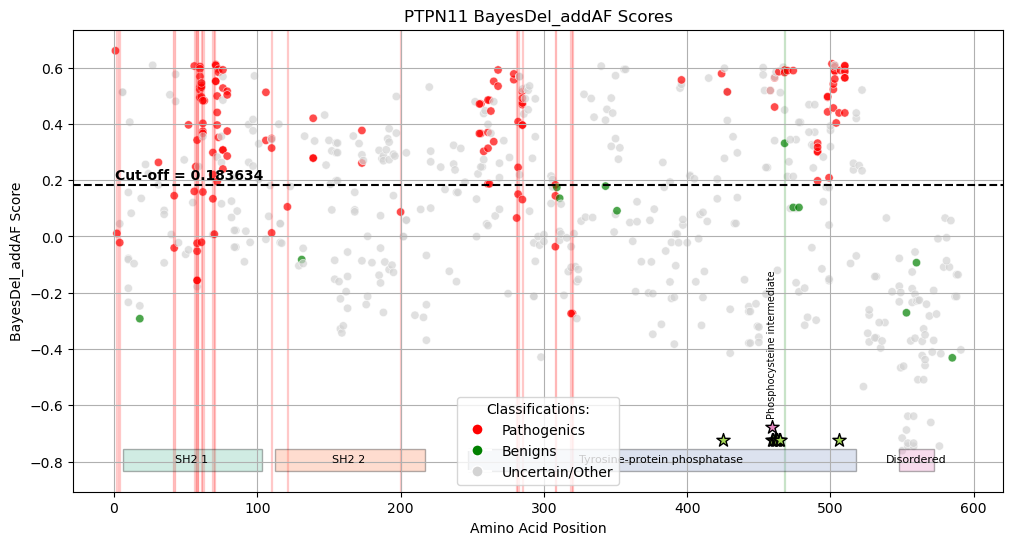

In [21]:
# REVEL
plot_score_by_position(
    PTPN11_REVEL_BayesDel_labeled_df,
    score='REVEL',
    cutoff=revel_cutoff,
    pred_col = 'Predicted_REVEL',
    domains=domains,
    sites=sites,
    title='PTPN11 REVEL Scores'
)

# BayesDel_noAF
plot_score_by_position(
    PTPN11_REVEL_BayesDel_labeled_df,
    score='BayesDel_noAF',
    cutoff=noaf_cutoff,
    pred_col = 'Predicted_BayesDel_noAF',
    domains=domains,
    sites=sites,
    title='PTPN11 BayesDel_noAF Scores'
)

# BayesDel_addAF
plot_score_by_position(
    PTPN11_REVEL_BayesDel_labeled_df,
    score='BayesDel_addAF',
    cutoff=addaf_cutoff,
    pred_col = 'Predicted_BayesDel_addAF',
    domains=domains,
    sites=sites,
    title='PTPN11 BayesDel_addAF Scores'
)

In [103]:
PTPN11_REVEL_BayesDel_labeled_df

,GRCh38Location,GRCh37Location,Germline classification,REVEL,BayesDel_noAF,BayesDel_addAF,AAfrom,AAto,AApos_ClinVar,Predicted_REVEL,Predicted_BayesDel_noAF,Predicted_BayesDel_addAF
0,112419113,112856917,Likely pathogenic,0.202,0.660000,0.660000,M,R,1,Benign,Pathogenic,Pathogenic
1,112419116,112856920,Pathogenic/Likely pathogenic,0.213,0.010807,0.010807,T,I,2,Benign,Benign,Benign
2,112419121,112856925,Conflicting classifications of pathogenicity,0.518,0.044882,0.044882,R,G,4,Benign,Benign,Benign
3,112419122,112856926,Likely pathogenic,0.393,-0.022043,-0.022043,R,Q,4,Benign,Benign,Benign
4,112446279,112884083,Uncertain significance,0.920,0.512606,0.512606,W,C,6,Pathogenic,Pathogenic,Pathogenic
...,...,...,...,...,...,...,...,...,...,...,...,...
583,112504745,112942549,Uncertain significance,0.182,-0.213665,-0.213665,Q,R,587,Benign,Benign,Benign
584,112504745,112942549,Uncertain significance,0.182,-0.213665,-0.213665,Q,R,588,Benign,Benign,Benign
585,112504748,112942552,Uncertain significance,0.248,-0.135998,-0.135998,Q,P,588,Benign,Benign,Benign
586,112504748,112942552,Uncertain significance,0.248,-0.135998,-0.135998,Q,P,589,Benign,Benign,Benign


In [97]:
# Pearson correlation (linear)
pearson_noAF = df_stat[['REVEL', 'BayesDel_noAF']].corr(method='pearson').iloc[0,1]
pearson_addAF = df_stat[['REVEL', 'BayesDel_addAF']].cor(method='pearson').iloc[0,1]

# Spearman correlation (rank-based)
spearman_noAF = df_stat[['REVEL', 'BayesDel_noAF']].corr(method='spearman').iloc[0,1]
spearman_addAF = df_stat[['REVEL', 'BayesDel_addAF']].corr(method='spearman').iloc[0,1]

print(f"REVEL vs BayesDel_noAF: Pearson={pearson_noAF:.3f}, Spearman={spearman_noAF:.3f}")
print(f"REVEL vs BayesDel_addAF: Pearson={pearson_addAF:.3f}, Spearman={spearman_addAF:.3f}")


REVEL vs BayesDel_noAF: Pearson=0.906, Spearman=0.907
REVEL vs BayesDel_addAF: Pearson=0.906, Spearman=0.907


In [98]:
def plot_score_correlation(df, score1='REVEL', score2='BayesDel_noAF', gene=None):
    # Drop NA values
    df_plot = df[[score1, score2]].dropna()

    # Compute correlation
    pearson_corr, _ = pearsonr(df_plot[score1], df_plot[score2])
    spearman_corr, _ = spearmanr(df_plot[score1], df_plot[score2])

    # Scatter plot with regression line
    plt.figure(figsize=(8,6))
    sns.regplot(x=score1, y=score2, data=df_plot, scatter_kws={'alpha':0.6})
    plt.xlabel(f"{score1} Score")
    plt.ylabel(f"{score2} Score")
    title = f"{gene + ' ' if gene else ''}{score1} vs {score2}"
    plt.title(title)
    plt.grid(True)
    plt.show()

    print(f"Pearson correlation ({score1} vs {score2}): {pearson_corr:.3f}")
    print(f"Spearman correlation ({score1} vs {score2}): {spearman_corr:.3f}")
    
    return pearson_corr, spearman_corr


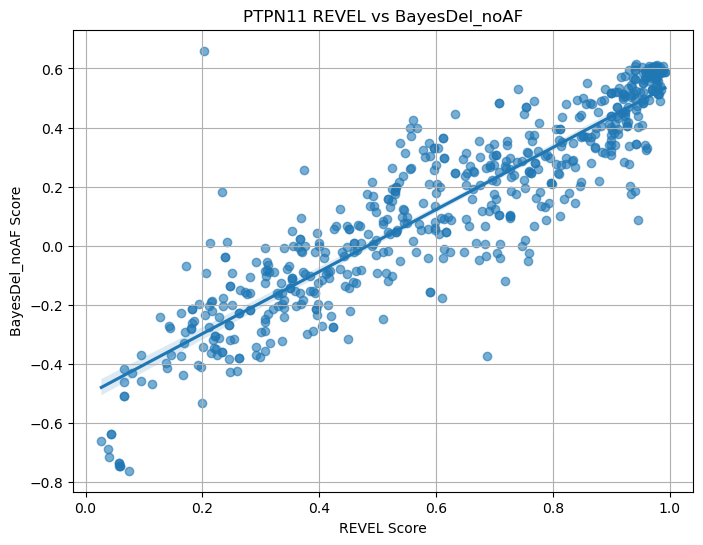

Pearson correlation (REVEL vs BayesDel_noAF): 0.906
Spearman correlation (REVEL vs BayesDel_noAF): 0.907


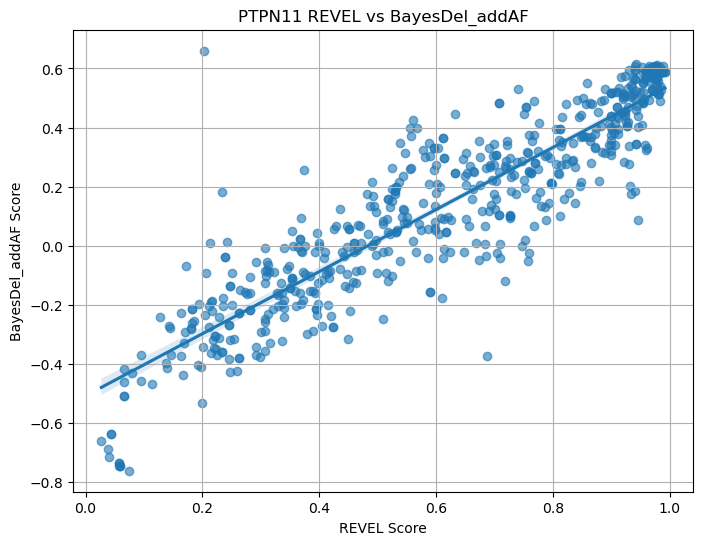

Pearson correlation (REVEL vs BayesDel_addAF): 0.906
Spearman correlation (REVEL vs BayesDel_addAF): 0.907


(np.float64(0.90590784144133), np.float64(0.9072129982469501))

In [99]:
# REVEL vs BayesDel_noAF
plot_score_correlation(df_stat, score1='REVEL', score2='BayesDel_noAF', gene='PTPN11')

# REVEL vs BayesDel_addAF
plot_score_correlation(df_stat, score1='REVEL', score2='BayesDel_addAF', gene='PTPN11')


In [101]:
def correlation_by_position_window(df, score1='REVEL', score2='BayesDel_noAF', position_col='AApos_ClinVar', window_size=50, gene=None, plot=True):
    # Make sure positions are numeric
    df = df.dropna(subset=[score1, score2, position_col])
    df[position_col] = pd.to_numeric(df[position_col], errors='coerce')
    
    min_pos = int(df[position_col].min())
    max_pos = int(df[position_col].max())
    
    bins = np.arange(min_pos, max_pos + window_size, window_size)
    bin_labels = [f"{b}-{b+window_size-1}" for b in bins[:-1]]
    
    df['pos_bin'] = pd.cut(df[position_col], bins=bins, labels=bin_labels, include_lowest=True)
    
    results = []
    for b in bin_labels:
        df_bin = df[df['pos_bin'] == b]
        if len(df_bin) >= 2:  # need at least 2 points to compute correlation
            pearson = df_bin[[score1, score2]].corr(method='pearson').iloc[0,1]
            spearman = df_bin[[score1, score2]].corr(method='spearman').iloc[0,1]
        else:
            pearson, spearman = np.nan, np.nan
        results.append({'bin': b, 'pearson': pearson, 'spearman': spearman, 'n': len(df_bin)})
    
    corr_df = pd.DataFrame(results)
    
    if plot:
        plt.figure(figsize=(12,5))
        plt.plot(corr_df['bin'], corr_df['pearson'], marker='o', label='Pearson')
        plt.plot(corr_df['bin'], corr_df['spearman'], marker='s', label='Spearman')
        plt.xticks(rotation=45)
        plt.xlabel('Amino Acid Position Bin')
        plt.ylabel('Correlation')
        plt.title(f"{gene+' ' if gene else ''}{score1} vs {score2} Correlation by Position (window={window_size})")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    
    return corr_df


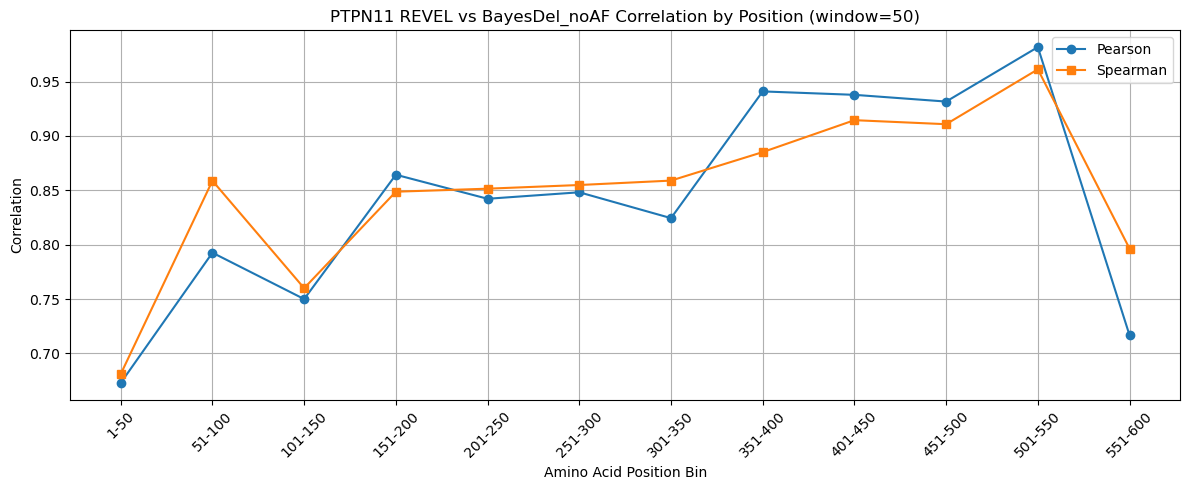

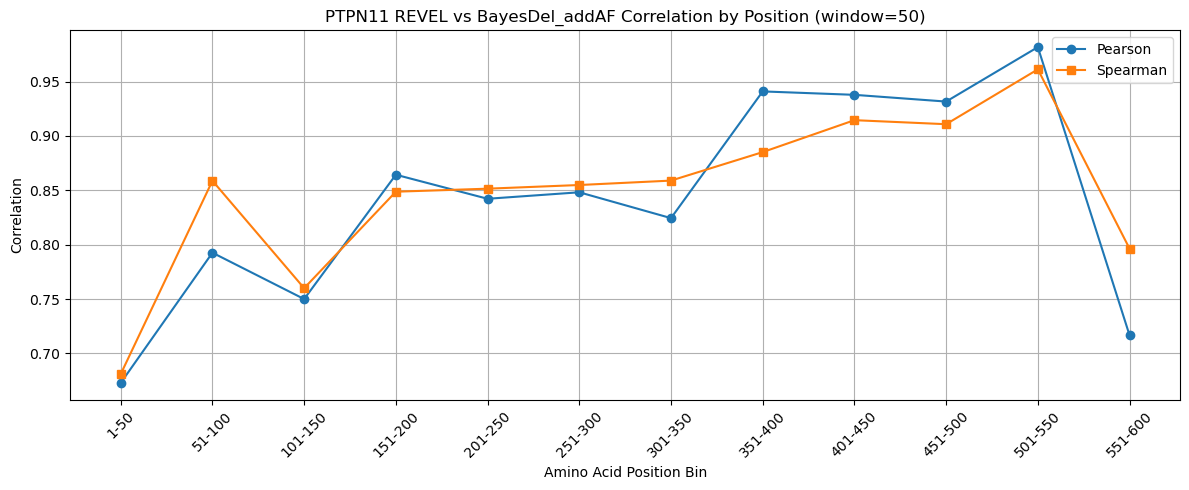

In [102]:
# REVEL vs BayesDel_noAF
corr_noAF = correlation_by_position_window(df_stat, score1='REVEL', score2='BayesDel_noAF', window_size=50, gene='PTPN11')

# REVEL vs BayesDel_addAF
corr_addAF = correlation_by_position_window(df_stat, score1='REVEL', score2='BayesDel_addAF', window_size=50, gene='PTPN11')
